In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from titanic_data import TitanicData, ModelInput
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
sns.set_theme(style='whitegrid')


## Fetch Data

In [2]:
t = TitanicData()
t.fetch_data()
t.breakout()

In [3]:
t.data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Section,CabinFlag,TicketType
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A5 21171,7.2500,NaN,S,Braund,not_available,0,A5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,C,1,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2 3101282,7.9250,NaN,S,Heikkinen,not_available,0,STON/O2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,C,1,GENERAL
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,not_available,0,GENERAL


## Initial EDA
A quick look to compare the available numerical features shows some promise with each Age, Fare, and Pclass.

In [4]:
def pair_plots(df):
    sns.pairplot(df,              
                 hue='Survived', 
                 height=4, 
                 plot_kws={'s': 100, 'alpha': 0.5})
    
def violin_plots(df, x, y):
    fig = plt.figure(figsize=(10, 8))
    sns.violinplot(x=x, y=y, 
                   hue='Survived', 
                   split=True, 
                   scale='count', 
                   inner='stick', 
                   data=df)
    plt.title(f'Distributions of Passengers by {x} and {y}', fontsize=18)
    plt.show()

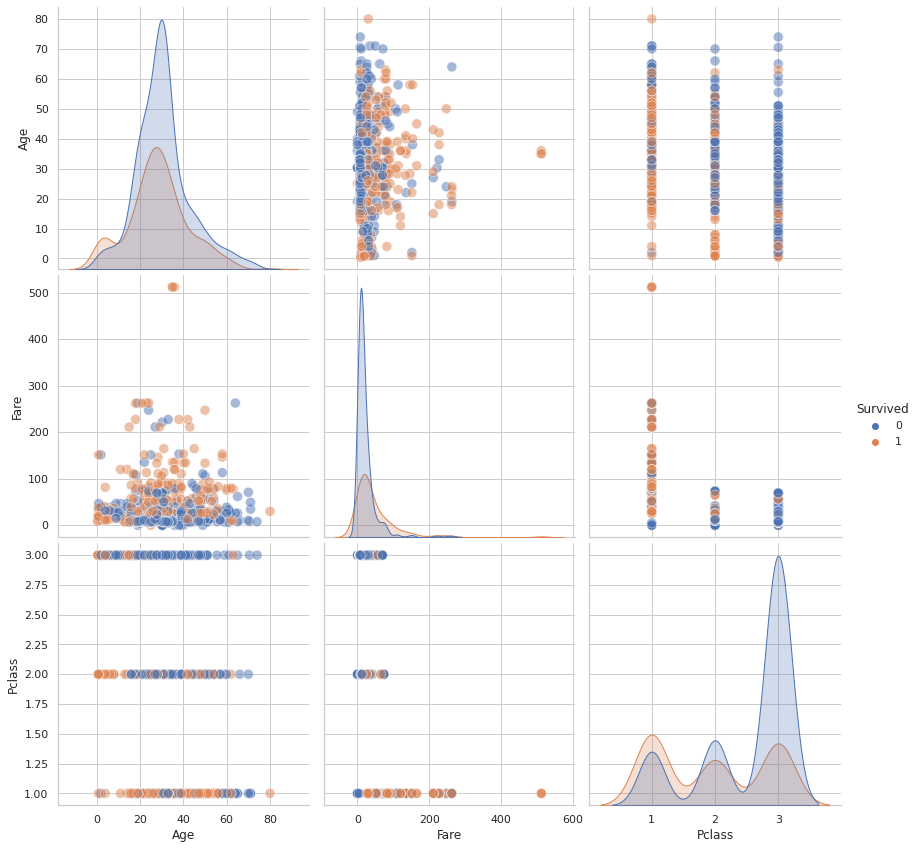

In [5]:
pair_plots(t.data.loc[:, ['Age', 'Fare', 'Pclass', 'Survived']])

We can immediately see from the pairplot that passengers were more likely not to survive if they were in Pclass 3. Also, the ranges of Age and Fare for survivors in Pclass 1 are larger. Interpretation: if one paid more for a ticket, one was more likely to survive despite his or her age. 

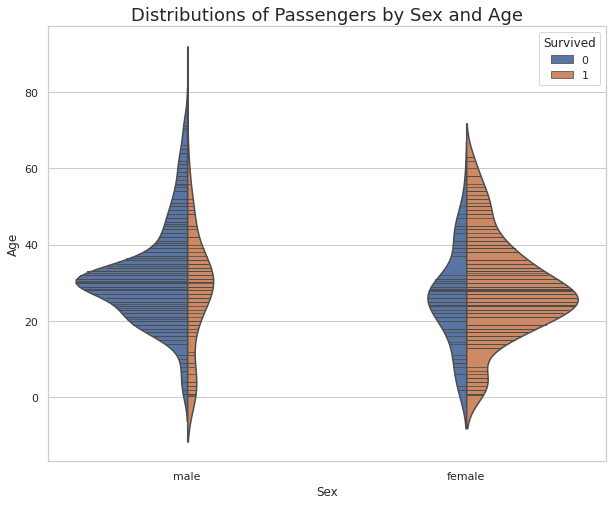

In [6]:
violin_plots(t.data, x='Sex', y='Age')

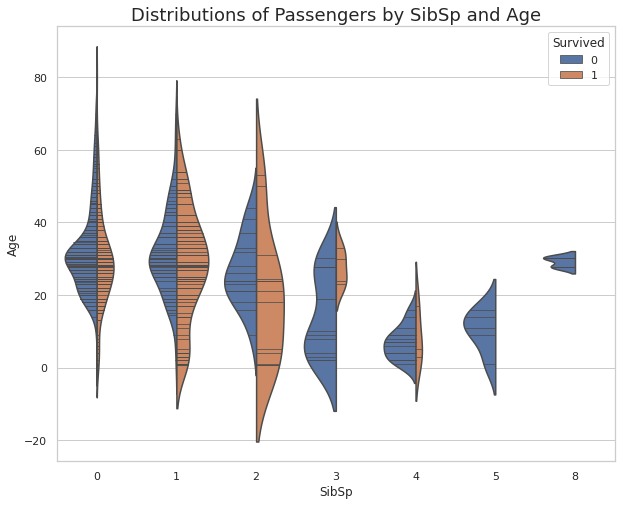

In [7]:
violin_plots(t.data, x='SibSp', y='Age')

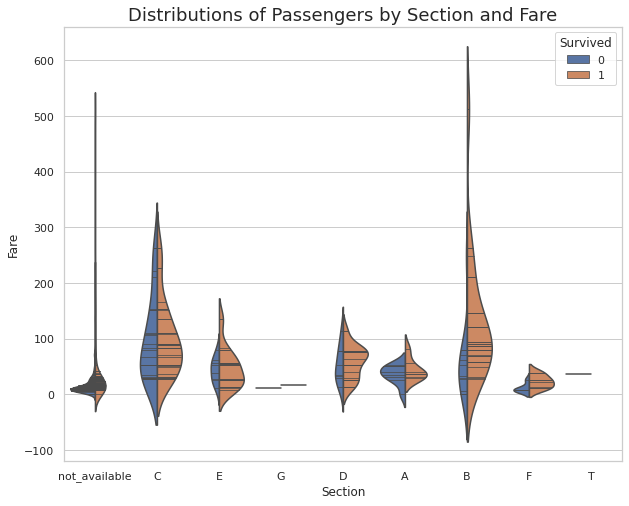

In [8]:
violin_plots(t.data, x='Section', y='Fare')

## Feature Engineering: First Impressions
New columns representing:
- Fill null Age values with average by Sex, Embarked
- Convert Pclass, Sex, SibSp, and Parch to categorical (get_dummies)
- CabinFlag: 1 or 0
- Cabin Section and make categorical
- LastName
- Scale (after train-test-split)

In [9]:
t.get_dummies()

In [10]:
t.data.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin',
       'LastName', 'CabinFlag', 'Pclass_2', 'Pclass_3', 'Sex_male', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_1',
       'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_Q',
       'Embarked_S', 'Section_B', 'Section_C', 'Section_D', 'Section_E',
       'Section_F', 'Section_G', 'Section_T', 'Section_not_available',
       'TicketType_A5', 'TicketType_C', 'TicketType_CA', 'TicketType_CA/SOTON',
       'TicketType_FC', 'TicketType_FCC', 'TicketType_Fa',
       'TicketType_GENERAL', 'TicketType_P/PP', 'TicketType_PC',
       'TicketType_PP', 'TicketType_SC', 'TicketType_SC/A4',
       'TicketType_SC/AH', 'TicketType_SC/PARIS', 'TicketType_SC/Paris',
       'TicketType_SCO/W', 'TicketType_SO/C', 'TicketType_SO/PP',
       'TicketType_SOC', 'TicketType_SOP', 'TicketType_SOTON/O2',
       'TicketType_SOTON/OQ', 'TicketType_SP', 'TicketType_STON/O2',
       'Ticke

## Build Input for Model
Set the features to be used for training the model. Then do a Train-Test Split and Scale Numerical Data.

In [11]:
mi = ModelInput(t.data, t.test_data)

mi.set_features()
mi.train_test_split(test_size=0.2)
mi.scale()

# Grid Search & Random Forest Classifier
Use GridSearchCV to iteratively train several Random Forest Classifers, find the best parameters, and make predictions. You can, then, visually inspect the results of grid search with `gs.cv_results_`.

In [12]:
params = {'n_estimators': [100, 300, 1000, 3000], 'max_depth': [2, 3, 5, 7, 9]}

rf = RandomForestClassifier(criterion='gini', 
                            n_jobs=2, 
                            random_state=4321)

gs = GridSearchCV(rf, params, verbose=1)
gs.fit(mi.X_train, mi.y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished


GridSearchCV(estimator=RandomForestClassifier(n_jobs=2, random_state=4321),
             param_grid={'max_depth': [2, 3, 5, 7, 9],
                         'n_estimators': [100, 300, 1000, 3000]},
             verbose=1)

In [13]:
gs.cv_results_

{'mean_fit_time': array([0.54613252, 0.64589734, 1.8950387 , 5.10086536, 0.23744926,
        0.57361431, 1.74450989, 4.82528343, 0.25053701, 0.61194539,
        1.83586826, 5.07488127, 0.24517765, 0.61582785, 1.98703737,
        5.36069112, 0.27734323, 0.66809072, 1.96011662, 5.13012557]),
 'std_fit_time': array([0.61695729, 0.04120578, 0.18801597, 0.14658665, 0.01006069,
        0.0098989 , 0.09853115, 0.18304279, 0.01661239, 0.01135651,
        0.14576975, 0.22949211, 0.01272849, 0.01891009, 0.14212033,
        0.2174712 , 0.0568066 , 0.03851487, 0.0570414 , 0.15817947]),
 'mean_score_time': array([0.10711069, 0.16905584, 0.34749517, 0.72860599, 0.10525732,
        0.1051754 , 0.3070991 , 0.70818806, 0.10519137, 0.1054801 ,
        0.30662336, 0.70813217, 0.10546155, 0.10534015, 0.30631704,
        0.7496738 , 0.105864  , 0.1459301 , 0.30717297, 0.70886593]),
 'std_score_time': array([0.00262157, 0.05202972, 0.05062415, 0.04031834, 0.00015265,
        0.00064074, 0.00138278, 0.000390

Optimized results from `gs.cv_results_` can be obtained by finding the min index of `gs.cv_results_['rank_test_score']`.

In [14]:
best_idx = gs.cv_results_['rank_test_score'].argmin()
best_params = gs.cv_results_['params'][best_idx]
print(f'Best Params: {best_params}')

Best Params: {'max_depth': 7, 'n_estimators': 1000}


## Apply Optimized Parameters to Classifier
An optimal max_depth of 7, especially for such a relatively small set of training data, makes me very suspicious that overfitting is occurring. In fact, dialing down this param did, indeed, improve the score by 0.012 upon submission of the predictions on the unseen data.

In [15]:
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                            max_depth=best_params['max_depth'], 
                            criterion='gini', 
                            n_jobs=2, 
                            random_state=4321)

rf.fit(mi.X_train, mi.y_train)
y_pred = rf.predict(mi.X_test)

# show scores
acc = accuracy_score(mi.y_test, y_pred)
f1 = f1_score(mi.y_test, y_pred)
cm = confusion_matrix(mi.y_test, y_pred)

print(f'Accuracy: \t{acc}')
print(f'F1: \t\t{f1}')
print(f'Confusion Matrix: \n{cm}')

Accuracy: 	0.8547486033519553
F1: 		0.7903225806451613
Confusion Matrix: 
[[104  10]
 [ 16  49]]


## Feature Importance

Text(0.5, 0, 'Average Contribution to Information Gain')

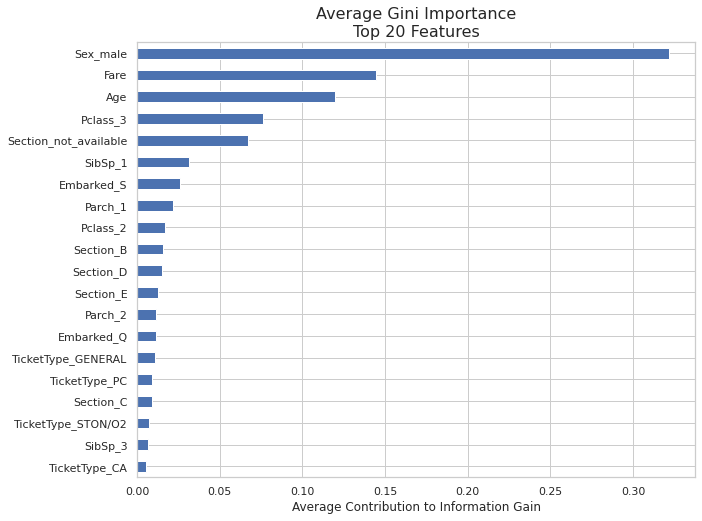

In [16]:
feat_scores = pd.Series(rf.feature_importances_, 
                        index=mi.X_train.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(10, 8))
ax.set_title('Average Gini Importance\nTop 20 Features', fontsize=16)
ax.set_xlabel('Average Contribution to Information Gain')

## Modifications
After the first runs, the TicketType features don't appear to have a significant bearing on predictions and may actually be adding noise to the data. A future crack at this may remove the `TicketType` features to see what we get.

# Unseen Test Data
Create predictions on unseen test data for submission. The features in unseen data were already modified and scaled in the ModelInput class.

Make predictions, write results to csv, then submit using the Kaggle API.

In [17]:
mi.hidden_data.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,TicketType_SO/PP,TicketType_SOC,TicketType_SOP,TicketType_SOTON/O2,TicketType_SOTON/OQ,TicketType_SP,TicketType_STON/O2,TicketType_SW/PP,TicketType_WC,TicketType_WEP
0,0.428248,0.015282,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.585323,0.013663,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.773813,0.018909,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.334004,0.016908,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.271174,0.023984,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y_pred_submit = rf.predict(mi.hidden_data)

In [19]:
submission = pd.DataFrame(data={
    'PassengerId': t.test_data.loc[:, 'PassengerId'], 
    'Survived': y_pred_submit})

submission.to_csv('../data/rf_output_opt_params.csv', index=False)

In [20]:
!kaggle competitions submit -c titanic -f ../data/rf_output_opt_params.csv -m "random forest classifier with optimized params"

100%|██████████████████████████████████████| 2.77k/2.77k [00:02<00:00, 1.15kB/s]
403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (6.4 hours from now).
